
# Alireza Salamat

### 810197526

## Machine Learning



In [1]:
from __future__ import unicode_literals
from hazm import *
from hazm import utils as utl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_selection
import math
import numpy as np

from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfVectorizer,
                                             TfidfTransformer)


<div dir='rtl'>
    در ابتدا دیتاست را میخوانیم و در یک دیتافریم ذخیره می کنیم
    </div>

In [2]:
train = pd.read_csv('vehicles.csv')
train = pd.DataFrame(train)
train

,brand,category,created_at,description,image_count,mileage,price,title,year
0,NaN,heavy,Tuesday 07PM,سریال 43j$NUMبدون شکستگی سه حلقه لاستیک نو یک ...,4,NaN,-1,لودر کاتر پیلار 950,NaN
1,سایر,light,Wednesday 04AM,دوگانه ال پی جی بیمه با تخفیف دارد \nتودوزی نو...,3,180000.0,-1,پاترول شش سیلندر چهار درب,1366
2,پژو ۴۰۵::Peugeot 405,light,Wednesday 11AM,پژو 2000فنی تازه تعمیر بدنه بدون خطو خش تخیف ب...,0,290000.0,8500000,پژو مدل 81 مشکی,1381
3,نیسان::Nissan,light,Wednesday 01PM,سلام.\nماشین کاملا سالم همه چی فابریک متور زد ...,3,175000.0,19500000,پاترول 2در,1372
4,سمند::Samand,light,Thursday 07AM,سمند ال ایکس بدون رنگ تمامی سرویس ها انجام شده...,4,80000.0,23900000,سمند دوگانه کارخانه,1391
...,...,...,...,...,...,...,...,...,...
130438,NaN,heavy,Wednesday 03PM,بادسان فوق بیرنگ سفید رنگ بیمه تابرج 3.96 تخفی...,2,NaN,48000000,بادسان 8b14 مدل83,NaN
130439,NaN,heavy,Wednesday 06PM,باسلام .تراکتورازصفری دست خودم بوده.سالم.ودارا...,4,NaN,-1,تراکتورگلدونی ۲۳۸ایتالیا,NaN
130440,سمند::Samand,light,Wednesday 06PM,ماشینم تصادفیه با خریدار توافق میکنم سر قیمتش,3,20000.0,-1,خودرو سمند تصادفی مدل92,1392
130441,پراید صندوق‌دار::Pride,light,Thursday 03PM,سند۲ برگ،بیمه تا برج$NUMتخفیفات بیمه 15 سال،مع...,4,123000.0,6900000,پراید 79 بسیار سالم,1379



<div dir='rtl'>
    داده های دسته ای را باید به صورتی در بیاوریم که قابل استفاده باشند. در ابتدا ردیف داده های از دست رفته (NaN)را حذف می کنیم.چون دیتاستمان بسیار بزرگ است تاثیر منفی زیادی بر روی نتیجه نهاییمان نمیگذارد.<br>
    برای قابل استفاده کردن ستون year این ستون را به عدد تبدیل می کنیم و همنین مقدار هایی که < 1366 دارند را با عدد ۱۳۵۵ جایگزین می کنیم.<br>
    ستون created at را به اینصورت در می آوریم که ساعت های هفته را نشان می دهند، یعنی روز هفته را در ۲۴ ضرب میکنیم و با ساعت آن روز جمع می کنیم.<br>
    برای ستون کتگوری به ماشین های سنگین برچسب ۱ و به ماشین های سبک برچسب صفر را می دهیم، البته ردیف ماشین های سنگین در حذف کردن داده های از دست رفته حذف شده است! <br>
    ستون برند را به این صورت تغییر می دهیم که یک دیکشنری از برند ماشین های موجود در دیتاست تهیه میکنیم و به هر برند یک شماره نسبت می دهیم و با آن برچسب گذاری می کنیم. <br>
</div>

In [3]:
train['year'] = train['year'].replace(to_replace='<1366', value='1355')
train['year'] = train['year'].fillna(value=train['year'].mode()[0])
train['mileage'] = train['mileage'].fillna(value=train['mileage'].mean())

train.dropna(inplace = True)

train['year'] = list(map(int, train['year']))


date_dict = {'Saturday': 0,
            'Sunday':1,
            'Monday':2,
            'Tuesday':3,
            'Wednesday':4,
            'Thursday':5,
            'Friday':6}

def date_converter(x):
    x = x.split()
    day = date_dict[x[0]]
    
    hour = 0
    if x[1][2] == 'A':
        if int(x[1][:2]) == 12:
            hour = 0
        hour = int(x[1][:2])
    else:
        if int(x[1][:2]) == 12:
            hour = 12
        hour = int(x[1][:2]) + 12
        
    return day * 24 + hour

train['created_at'] = list(map(date_converter, train['created_at']))
train['category'] = train['category'].replace(to_replace = ['light', 'heavy'], value = [0, 1])

index = 0
brand_dict = dict()
for i in train['brand'].unique():
    brand_dict.update({i:index})
    index += 1
train['brand'] = train['brand'].replace(brand_dict)



<div dir='rtl'>
   در قطعه کد زیر، ردیف هایی که قیمت ندارند را از دیتاست اصلی خارح می کنیم و در دیتاست دیگری نگه داری می کنیم. 
</div>

In [4]:
grouped = train.groupby(train.price)
df_noPrice = grouped.get_group(-1)
train = train[train['price'] != -1]
df_noPrice

,brand,category,created_at,description,image_count,mileage,price,title,year
1,0,0,100,دوگانه ال پی جی بیمه با تخفیف دارد \nتودوزی نو...,3,180000.0,-1,پاترول شش سیلندر چهار درب,1366
11,7,0,6,پژو پارس سفید ،بدون رنگ ،ازنظر فنی کاملا سالم،...,2,108000.0,-1,پژو پارس سفید 88بدون رنگ,1388
23,10,0,80,گلگیر سمت راننده رنگ دارد متوری تمیز بدون ظربه,0,20000.0,-1,پراید بار ١٥١,1393
37,14,0,34,هفت سال تخفیف بیمه.عقب جلو پلم.بدون هیچ روغن ر...,2,114000.0,-1,زانتیا 88,1388
45,8,0,83,فنى وبدنه بسیارسالم ٣لکه رنگ شدگى,4,138000.0,-1,پژو٢٠٦مدل١٣٨٥,1385
...,...,...,...,...,...,...,...,...,...
130402,1,0,136,مدل 88دوتکه رنگ رنگ نوک مدادی داری دزدگیرکفپوش...,0,160000.0,-1,خودروپژو405,1388
130417,3,0,72,سمند مدل 92 موتوری به شرط \nبدون رنگ .خط و خش ...,3,100000.0,-1,فروش سمند LX. ef7,1392
130434,10,0,64,ماشین سالم . یک گلگیر رنگ . بیمه تا برج ۷ سال ...,3,199000.0,-1,وانت پیکان مدل ۸۴,1384
130437,1,0,104,۴۰۵slxیا همان tufصفر کیلومتر سند خورده تحویل د...,3,1.0,-1,۴۰۵slx,1395


In [5]:
from sklearn.model_selection import train_test_split

x = train.drop(['price', 'title', 'description'], 1)
y = train.price
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)
X_train

,brand,category,created_at,image_count,mileage,year
118436,5,0,16,2,167.0,1391
64867,12,0,65,0,70000.0,1393
89222,1,0,86,0,240000.0,1382
2103,5,0,151,1,470000.0,1393
114777,5,0,63,1,100000.0,1393
...,...,...,...,...,...,...
26756,8,0,35,1,24000.0,1394
57824,0,0,35,2,200.0,1381
53655,23,0,147,0,360000.0,1369
54880,1,0,99,2,147.0,1388


<div dir='rtl'>
پرسش ۱:<br>
    با توجه به نمودار زیر می بینیم که ویژگی brand بیشترین gain را می دهد و بعد از آن year و mileage قرار دارد. <br>
    ویژگی های created at  و image count گین بسیار کمی دارند و می توان گفت اطلاعات خاصی به ما اضافه نمی کند.<br>
    مقدار های nan ویژگی year را با mode و ویژگی mileage را با میانگین پر می کنیم. و ردیف مقدارهای nan ویژگی brand را دراپ می کنیم.
</div>

brand          0.731711
category       0.000000
created_at     0.002423
image_count    0.012720
mileage        0.237517
year           0.552746
dtype: float64


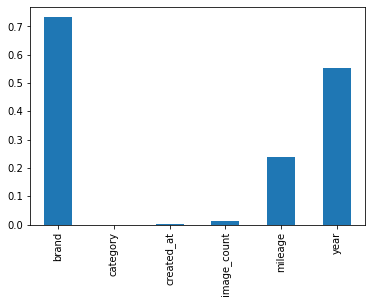

In [6]:
mi = mutual_info_regression(X_train, y_train)

import matplotlib.pyplot as plt
mi = pd.Series(mi)
mi.index = X_train.columns
print(mi)

import matplotlib.pyplot as plt
mi = pd.Series(mi)
mi.index = X_train.columns
mi.plot.bar()
plt.show()



<div dir='rtl'>
   مجموعه stop words را در زیر می سازیم:
</div>

In [7]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stop_words = open('stopwords', 'r').read().splitlines()
stop_words = [lemmatizer.lemmatize(w) for w in stop_words]
stop_words.append('\n')
stop_words.append('\r')



<div dir='rtl'>
   ستون های ویژگی های title و description را یکی می کنیم.
</div>

In [8]:
train['description'] = train['description'] + ' ' + train['title']
train = train.drop('title', 1)


<ipython-input-8-2ae0b4267468>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['description'] = train['description'] + ' ' + train['title']


In [9]:
train['description'] = train['description'].apply(lambda x: normalizer.normalize(x))
train['description'] = train['description'].apply(lambda x: word_tokenize(x))

train['description'] = train['description'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

train['description'] = train['description'].apply(lambda x: [i for i in x if i not in stop_words])

train['description'] = train['description'].apply(lambda x: ' '.join(x))



<div dir='rtl'>
   پرسش ۲: <br>
    داده های دسته ای را برچسب گذاری کرده ایم به این صورت که مثلا برای brand هر کدام از برندها را یک برچسب عددی به آن اختصاص داده ایم.<br> 
      بقیه داده های دسته ای در بالاتر توضیح داده شده اند.<br><br>
    پرسش ۳: حال با استفاده از tf idf و count vectorizer کلمات پرتکرار متن را بدست می آوریم. این کلمات را به صورت ngram انتخاب کرده ایم تا دقت بیشتری داشته باشد. مقایسه این دو روش در قسمت های بعدی نمایش داده شده است.<br><br>
    پرسش ۴: در بالاتر نحوه برخورد با داده های از دست رفته توضیح داده شده است.
</div>


<div dir='rtl'>
   با استفاده از tf idf کلمات پر تکرار ستون توضیحات و تایتل را بدست می آوریم و ۴۰ تای بیشتر آن ها را به عنوان ویژگی جدید دیتاست اضافه می کنیم. به طرزی که به دیتاست ۵۰ ستون اضافه می شود. <br>
    همان طور که در زیر می بینیم کلمه های که از دو روش تولید شده اند دقیقا عین هم می باشند.
</div>

In [10]:
vectorizer1 = TfidfVectorizer(analyzer='word', min_df=350, max_features=40, ngram_range=(3,8))  
vectorized1 = vectorizer1.fit_transform(train['description'])
new_df1 = pd.DataFrame(vectorized1.toarray(), columns=vectorizer1.get_feature_names())
print('Tf Idf words:')
print(new_df1.columns)

vectorizer2 = CountVectorizer(analyzer='word',min_df=350, max_features=40, ngram_range=(3, 8))
vectorized2 = vectorizer2.fit_transform(train['description'])
new_df2 = pd.DataFrame(vectorized2.toarray(), columns=vectorizer2.get_feature_names())
print('Count vectorizer words:')
print(new_df1.columns)

Tf Idf words:
Index(['ال پی جی', 'بیمه آخر سال', 'بیمه اخر سال', 'بیمه برج سال',
       'بیمه برج ۱۰', 'بیمه برج ۱۱', 'بیمه برج ۱۲', 'بیمه برج ۹۶',
       'بیمه سال تخفیف', 'تخفیف بیمه سال', 'تخفیف پای معامله', 'تک برگ سند',
       'جلو عقب پلمپ', 'حلقه لاستیک نو', 'دوگانه سی ان', 'دوگانه سی ان جی',
       'رنگ بیمه برج', 'رنگ خط خش', 'رنگ فن سالم', 'رنگ نوک مدادی',
       'سال تخفیف بیمه', 'سمند ال ایکس', 'سی ان جی', 'عقب جلو پلمپ',
       'فن العاده سالم', 'فن سالم بیمه', 'فن سالم رنگ', 'فن سالم شرط',
       'لاستیک جلو نو', 'لاستیک نو بیمه', 'لاستیک ۷۰ درصد', 'لاستیک ۸۰ درصد',
       'مصرف کننده تماس', 'پراید صندوق دار', 'پراید هاچ بک', 'پژو پارس مدل',
       'پژو ۲۰۶ تیپ', 'پژو ۲۰۶ مدل', 'پژو ۴۰۵ مدل', '۱۰ سال تخفیف'],
      dtype='object')
Count vectorizer words:
Index(['ال پی جی', 'بیمه آخر سال', 'بیمه اخر سال', 'بیمه برج سال',
       'بیمه برج ۱۰', 'بیمه برج ۱۱', 'بیمه برج ۱۲', 'بیمه برج ۹۶',
       'بیمه سال تخفیف', 'تخفیف بیمه سال', 'تخفیف پای معامله', 'تک برگ سند',
       'جل

<div dir='rtl'>
حال ستون کلمه هایی که پیدا کردیم را به دیتاست اضافه می کنیم.
</div>

In [11]:
df1 = train.copy()
df2 = train.copy()
df1[vectorizer1.get_feature_names()] = new_df1[vectorizer1.get_feature_names()].values
df2[vectorizer2.get_feature_names()] = new_df2[vectorizer2.get_feature_names()].values
df1 = df1.drop('description', 1)
df2 = df2.drop('description', 1)

<div dir='rtl'>
تایع های زیر برای بدست آوردن mse و rmse استفاده می شوند.
</div>

In [12]:
from sklearn.metrics import mean_squared_error

def trains(model,X_train, X_test, y_train):
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    return y_pred

def test(y_test, y_pred):
    mse = mean_squared_error(np.array(y_test), y_pred)
    rmse = mean_squared_error(np.array(y_test), y_pred, squared = False)
    return mse,rmse

## decision tree with tf idf
<div dir='rtl'>
  در زیر مدل decision tree با استفاده از tf idf بررسی شده است که با گذاشتن grid search cv پارامترهای بهینه را هم بدست آورده ایم.
</div>

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

x = df1.drop('price', 1)
y = df1.price
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

param_grid = {
    'max_depth': range(3,20),
    'min_samples_split': range(2,20)
}


clf = DecisionTreeRegressor(max_depth = 8, min_samples_split= 24)
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs = -1, return_train_score=True)
grid_r = grid_search.fit(X_train, y_train)
print(grid_r.best_params_, grid_r.best_score_)

y_pred = trains(clf, X_train, X_test, y_train)
mse, rmse = test(y_test, y_pred)

mse,rmse

{'max_depth': 8, 'min_samples_split': 18} 0.7586051294643456


(144309951390427.7, 12012907.69923867)


<div dir='rtl'>
  حال پارامترهای بهینه ای که بدست آمده است را جایگزین می کنیم و دوباره مدل را اجرا می کنیم. که می بینیم دقت مدل کمی بهتر شده است. <br>
    در زیر پارامتر min_smaples_split را ۱۹ گذاشتیم با اینکه در بالا ۱۸ بدست آمده است زیرا با هر دفعه ران کردن grid search cv، عدد متفاوتی به ما می دهد که ۱۹ از همه آنها بهینه تر است
</div>


In [66]:
x = df1.drop('price', 1)
y = df1.price
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

clf = DecisionTreeRegressor(max_depth = 9, min_samples_split= 19)

y_pred = trains(clf, X_train, X_test, y_train)
mse, rmse = test(y_test, y_pred)

mse,rmse

(150735388753259.6, 12277434.127424981)

## decision tree count vectorizer
<div dir='rtl'>
  در زیر مدل decision tree با استفاده از count vectorizer بررسی شده است که با گذاشتن grid search cv پارامترهای بهینه را هم بدست آورده ایم.
</div>

In [69]:
x = df2.drop('price', 1)
y = df2.price
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

param_grid = {
    'max_depth': range(3,20),
    'min_samples_split': range(2, 20)
}


clf = DecisionTreeRegressor(max_depth = 8, min_samples_split= 24)
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs = -1, return_train_score=True)
grid_r = grid_search.fit(X_train, y_train)
print(grid_r.best_params_, grid_r.best_score_)

y_pred = trains(clf, X_train, X_test, y_train)
mse, rmse = test(y_test, y_pred)

mse,rmse

{'max_depth': 9, 'min_samples_split': 19} 0.7686163618753762


(162590235646232.34, 12751087.626011843)

## linear regression

In [59]:
from sklearn.linear_model import LinearRegression

x = df1.drop('price', 1)
y = df1.price
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)

reg = LinearRegression()
y_pred = trains(reg,X_train, X_test, y_train)
mse, rmse = test(y_test, y_pred)

mse,rmse

(513561346088649.2, 22661891.93533164)

## k nearest neighbour

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)


param_grid_knn = {
    'n_neighbors': range(3, 10, 20)
}

knn = KNeighborsRegressor(n_neighbors=10)
grid_search = GridSearchCV(estimator = knn, param_grid = param_grid_knn, n_jobs = -1, return_train_score=True)
grid_r = grid_search.fit(X_train, y_train)
print(grid_r.best_params_, grid_r.best_score_)
y_pred = trains(knn,X_train, X_test, y_train)
mse, rmse = test(y_test, y_pred)

mse,rmse


<div dir='rtl'>
پرسش ۵: <br>
  نسبت داده های تست به تمرین ۱ به ۹ تقسیم شده است. در زیر برای مدل linear regression داده ها را به نسبت های دیگری تقسیم می کنیم. <br>
    همانطور که می بینیم برای نسبت 0.002 تست، نتایج رنج مختلفی دارد و قابل پیش بینی نیست.
    
</div>


In [76]:
from sklearn.linear_model import LinearRegression

x = df1.drop('price', 1)
y = df1.price

reg = LinearRegression()
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.6)
    y_pred = trains(reg,X_train, X_test, y_train)
    mse, rmse = test(y_test, y_pred)

    print('\ntest no.', i,' linear regression with 0.6 data for test:')
    print('mse: ', mse, '   rmse: ', rmse)



test no. 0  linear regression with 0.6 data for test:
mse:  531960897233311.0    rmse:  23064277.51379416

test no. 1  linear regression with 0.6 data for test:
mse:  531557403464544.94    rmse:  23055528.696270335

test no. 2  linear regression with 0.6 data for test:
mse:  530889317942593.06    rmse:  23041035.52235865

test no. 3  linear regression with 0.6 data for test:
mse:  528485424910124.25    rmse:  22988810.863333587

test no. 4  linear regression with 0.6 data for test:
mse:  535637665631137.7    rmse:  23143847.25215619

test no. 5  linear regression with 0.6 data for test:
mse:  533365087893474.3    rmse:  23094698.263746038

test no. 6  linear regression with 0.6 data for test:
mse:  533659747296049.56    rmse:  23101076.756204452

test no. 7  linear regression with 0.6 data for test:
mse:  525174021986861.9    rmse:  22916675.63122675

test no. 8  linear regression with 0.6 data for test:
mse:  531167914327738.7    rmse:  23047080.386195097

test no. 9  linear regressi

In [121]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.002)
    y_pred = trains(reg,X_train, X_test, y_train)
    mse, rmse = test(y_test, y_pred)

    print('\ntest no.', i,' linear regression with 0.002 data for test:')
    print('mse: ', mse, '   rmse: ', rmse)


test no. 0  linear regression with 0.002 data for test:
mse:  522469836247477.4    rmse:  22857599.091931712

test no. 1  linear regression with 0.002 data for test:
mse:  324414863274691.06    rmse:  18011520.293264836

test no. 2  linear regression with 0.002 data for test:
mse:  383514625549381.9    rmse:  19583529.445668925

test no. 3  linear regression with 0.002 data for test:
mse:  272261400795079.06    rmse:  16500345.475022003

test no. 4  linear regression with 0.002 data for test:
mse:  499138387187721.06    rmse:  22341405.219630234

test no. 5  linear regression with 0.002 data for test:
mse:  523428778468352.9    rmse:  22878565.918089204

test no. 6  linear regression with 0.002 data for test:
mse:  726925997377039.4    rmse:  26961565.18781948

test no. 7  linear regression with 0.002 data for test:
mse:  611687741303081.4    rmse:  24732321.79361819

test no. 8  linear regression with 0.002 data for test:
mse:  498706908808477.9    rmse:  22331746.658254877

test no.


<div dir='rtl'>
     در یادگیری ماشین هنگامی که عملکرد یادگیری بسیار خوب باشد، اما عملکرد تخمین آن مدل بر روی دیتاست دیگری خوب نباشد overfitting می گوییم.<br>
     زمانی که عملکرد یادگیری خوب نباشد و حتی برای دیتاستی که از روی آن ترین  شده است نتواند خوب جواب دهد underfitting رخ داده است.<br><br>
پرسش ۶: <br>
 در زیر برای ارتفاع های مختلف درخت تصمیم را اجرا کرده ایم.
</div>


In [114]:
x = df2.drop('price', 1)
y = df2.price
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

new_dict = {'depth': list(),
           'mse': list(),
           'rmse': list()}

for i in range(2, 40, 3):
    clf = DecisionTreeRegressor(max_depth = i, min_samples_split= 19)
    y_pred = trains(clf, X_train, X_test, y_train)
    mse, rmse = test(y_test, y_pred)
    new_dict['depth'].append(i)
    new_dict['mse'].append(mse)
    new_dict['rmse'].append(rmse)
    print('Decision Tree depth: ', i, 'mse: ',mse, 'rmse: ', rmse)


Decision Tree depth:  2 mse:  434787077917822.75 rmse:  20851548.57361493
Decision Tree depth:  5 mse:  216956242150185.66 rmse:  14729434.54957405
Decision Tree depth:  8 mse:  169824767866449.4 rmse:  13031683.23227853
Decision Tree depth:  11 mse:  185687483269014.66 rmse:  13626719.461008018
Decision Tree depth:  14 mse:  204285880819488.94 rmse:  14292861.183803925
Decision Tree depth:  17 mse:  216111424419308.97 rmse:  14700728.70368367
Decision Tree depth:  20 mse:  223782775844749.3 rmse:  14959370.837195972
Decision Tree depth:  23 mse:  228267165609405.16 rmse:  15108513.017812347
Decision Tree depth:  26 mse:  229888957478066.25 rmse:  15162089.48259
Decision Tree depth:  29 mse:  230389730803867.38 rmse:  15178594.493689703
Decision Tree depth:  32 mse:  231270101397797.0 rmse:  15207567.241271596
Decision Tree depth:  35 mse:  229445064587371.12 rmse:  15147444.160232812
Decision Tree depth:  38 mse:  228700361648532.06 rmse:  15122842.379940752


<AxesSubplot:xlabel='depth'>

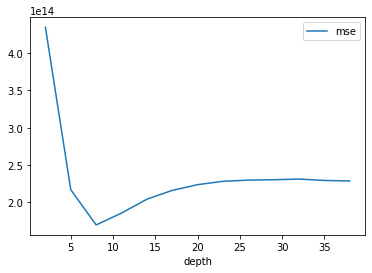

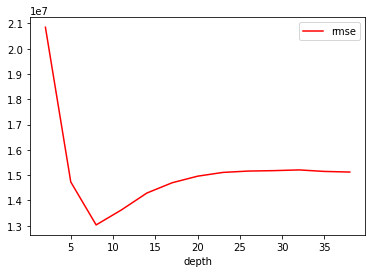

In [115]:
d = pd.DataFrame(new_dict, columns=new_dict.keys())
d.plot(x='depth', y='mse', kind='line')
d.plot(x='depth', y='rmse', kind='line', colormap='flag')



<div dir='rtl'>
 <br>
 همانطور که در نمودار های بالا مشخص است، در ارتفاع های بسیار کم خطا بسیار زیاد است. در ارتفاع های بین ۵ تا ۱۵ در کمترین میزان های خود است ولی با اضافه شدن ارتفاع می بینیم که خطا بیشتر می شود و در ارتفاع های زیاد دیگر نغییری نمی کند و ثابت می ماند. 
</div>


## ‫‪random‬‬ ‫‪forest‬‬

In [1]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

param_grid = {
    'min_weight_fraction_leaf': [0, 1, 1.5, 3.2, 5.8, 8.4, 10.7],
    'min_samples_leaf': range(1,10, 3),   
}


rfr = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3)
y_pred = trains(rfr,X_train, X_test, y_train)
grid_r = grid_search.fit(X_train, y_train)
print(grid_r.best_params_, grid_r.best_score_)
mse, rmse = test(y_test, y_pred)
mse, rmse

NameError: name 'train_test_split' is not defined

In [ ]:
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(param_grid['max_depth']),
                                  len(param_grid['min_samples_leaf']), len(param_grid['min_weight_fraction_leaf']))

# for ind, i in enumerate(Cs):
#     plt.plot(Gammas, scores[ind], label='C: ' + str(i))
# plt.legend()
# plt.xlabel('Gamma')
# plt.ylabel('Mean score')
# plt.show()
